In [37]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [38]:
from dotenv import load_dotenv
load_dotenv()

True

In [39]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [40]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [41]:
@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

tools = [get_stock_price]

llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

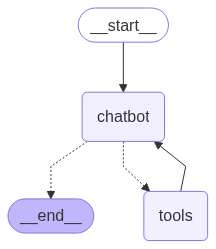

In [42]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")
graph = builder.compile(checkpointer=memory)

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [43]:
config1 = { 'configurable': { 'thread_id': '1'} }

msg = "I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config1)
print(state["messages"][-1].content)

The current price for AMZN is 150 and for MSFT is 200.3.
The total cost for 20 AMZN stocks is 20 * 150 = 3000
The total cost for 15 MSFT stocks is 15 * 200.3 = 3004.5
The grand total is 3000 + 3004.5 = 6004.5


In [44]:
config2 = { 'configurable': { 'thread_id': '2'} }

msg = "Tell me the current price of 5 AAPL stocks."

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config2)
print(state["messages"][-1].content)

The current price of one AAPL stock is $100.4. Therefore, the current price of 5 AAPL stocks is $502.


In [45]:
msg = "Using the current price tell me the total price of 10 RIL stocks and add it to previous total cost"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config1)
print(state["messages"][-1].content)

The current price of RIL is 87.6. The cost of 10 RIL stocks is 10 * 87.6 = 876. Adding this to the previous total cost of 6004.5, the new total is 6004.5 + 876 = 6880.5.


In [46]:
msg = "Tell me the current price of 5 MSFT stocks and add it to previous total"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config2)
print(state["messages"][-1].content)

The current price of one MSFT stock is $200.3. Therefore, the current price of 5 MSFT stocks is $1001. Adding that to the previous total of $502, the new total is $1503.
